In [1]:
//%maven org.nd4j:nd4j-cuda-9.0:1.0.0-beta
//%maven org.deeplearning4j:deeplearning4j-cuda-9.0:1.0.0-beta
//%maven org.datavec:datavec-api:1.0.0-beta
//%maven org.knowm.xchart:xchart:3.5.2
%maven org.deeplearning4j:deeplearning4j-zoo:1.0.0-beta

%maven org.nd4j:nd4j-native-platform:1.0.0-beta
%maven org.deeplearning4j:deeplearning4j-core:1.0.0-beta
%maven org.datavec:datavec-api:1.0.0-beta

In [2]:
import org.datavec.api.util.ClassPathResource;
import org.datavec.image.loader.NativeImageLoader;
import org.deeplearning4j.nn.api.Layer;
import org.deeplearning4j.nn.graph.ComputationGraph;
import org.deeplearning4j.nn.workspace.LayerWorkspaceMgr;
import org.deeplearning4j.zoo.PretrainedType;
import org.deeplearning4j.zoo.ZooModel;
import org.deeplearning4j.zoo.model.VGG16;
import org.nd4j.linalg.api.ndarray.INDArray;
import org.nd4j.linalg.dataset.api.preprocessor.DataNormalization;
import org.nd4j.linalg.dataset.api.preprocessor.VGG16ImagePreProcessor;
import org.nd4j.linalg.factory.Nd4j;
import org.nd4j.linalg.indexing.BooleanIndexing;
import org.nd4j.linalg.indexing.conditions.Conditions;
import org.nd4j.linalg.indexing.functions.Value;
import org.nd4j.linalg.learning.AdamUpdater;
import org.nd4j.linalg.learning.config.Adam;
import org.nd4j.linalg.ops.transforms.Transforms;
import org.slf4j.Logger;
import org.slf4j.LoggerFactory;

import javax.imageio.ImageIO;
import java.awt.*;
import java.awt.image.BufferedImage;
import java.io.File;
import java.io.IOException;
import java.net.URL;
import java.util.HashMap;
import java.util.Map;
import java.util.concurrent.ThreadLocalRandom;


In [3]:
private static final String CONTENT_LAYER_NAME = "block4_conv2";
private static final double BETA_MOMENTUM = 0.8;
private static final double BETA2_MOMENTUM = 0.999;
private static final double EPSILON = 0.00000008;

/**
 * Values suggested by
 * https://harishnarayanan.org/writing/artistic-style-transfer/
 * Other Values(5,100): http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style
 */
private static final double ALPHA = 0.025;
private static final double BETA = 5.0;

private static final double LEARNING_RATE = 2;
private static final double NOISE_RATION = 0.1;
private static final int ITERATIONS = 1000;

private static final String CONTENT_FILE = "/home/bzr0014/git/dl4j-examples/dl4j-examples/src/main/resources/styletransfer/content.jpg";
private static final String STYLE_FILE = "/home/bzr0014/git/dl4j-examples/dl4j-examples/src/main/resources/styletransfer/style.jpg";
private static final int SAVE_IMAGE_CHECKPOINT = 5;
private static final String OUTPUT_PATH = "/styletransfer/out/";

private static final int HEIGHT = 224;
private static final int WIDTH = 224;
private static final int CHANNELS = 3;
private static final DataNormalization IMAGE_PRE_PROCESSOR = new VGG16ImagePreProcessor();
private static final NativeImageLoader LOADER = new NativeImageLoader(HEIGHT, WIDTH, CHANNELS);


[IJava-executor-0] INFO org.nd4j.linalg.factory.Nd4jBackend - Loaded [CpuBackend] backend
[IJava-executor-0] INFO org.nd4j.nativeblas.NativeOpsHolder - Number of threads used for NativeOps: 4
[IJava-executor-0] INFO org.nd4j.nativeblas.Nd4jBlas - Number of threads used for BLAS: 4
[IJava-executor-0] INFO org.nd4j.linalg.api.ops.executioner.DefaultOpExecutioner - Backend used: [CPU]; OS: [Linux]
[IJava-executor-0] INFO org.nd4j.linalg.api.ops.executioner.DefaultOpExecutioner - Cores: [8]; Memory: [4.9GB];
[IJava-executor-0] INFO org.nd4j.linalg.api.ops.executioner.DefaultOpExecutioner - Blas vendor: [OPENBLAS]


In [4]:
private ComputationGraph loadModel() throws IOException {
    ZooModel zooModel = VGG16.builder().build();
    ComputationGraph vgg16 = (ComputationGraph) zooModel.initPretrained(PretrainedType.IMAGENET);
    vgg16.initGradientsView();
    return vgg16;
}
private INDArray loadImage(String contentFile) throws IOException {
    INDArray content = LOADER.asMatrix(new File(contentFile));
    IMAGE_PRE_PROCESSOR.transform(content);
    return content;
}
private BufferedImage imageFromINDArray(INDArray array) {
    int[] shape = array.shape();

    long height = shape[2];
    long width = shape[3];
    BufferedImage image = new BufferedImage((int)width, (int)height, BufferedImage.TYPE_INT_RGB);
    for (int x = 0; x < width; x++) {
        for (int y = 0; y < height; y++) {
            int red = array.getInt(0, 2, y, x);
            int green = array.getInt(0, 1, y, x);
            int blue = array.getInt(0, 0, y, x);

            //handle out of bounds pixel values
            red = Math.min(red, 255);
            green = Math.min(green, 255);
            blue = Math.min(blue, 255);

            red = Math.max(red, 0);
            green = Math.max(green, 0);
            blue = Math.max(blue, 0);
            image.setRGB(x, y, new Color(red, green, blue).getRGB());
        }
    }
    return image;
}

In [5]:
ComputationGraph vgg16FineTune = loadModel();

[IJava-executor-0] INFO org.deeplearning4j.zoo.ZooModel - Using cached model at /home/bzr0014/.deeplearning4j/vgg16_dl4j_inference.zip
[IJava-executor-0] INFO org.deeplearning4j.zoo.ZooModel - Verifying download...
[IJava-executor-0] INFO org.deeplearning4j.zoo.ZooModel - Checksum local is 3501732770, expecting 3501732770
[IJava-executor-0] INFO org.deeplearning4j.nn.graph.ComputationGraph - Starting ComputationGraph with WorkspaceModes set to [training: NONE; inference: SINGLE], cacheMode set to [NONE]


In [6]:
Map<String, INDArray> paramsTable = vgg16FineTune.paramTable();

In [7]:
paramsTable.keySet()

[block1_conv1_b, block1_conv1_W, block1_conv2_b, block1_conv2_W, block2_conv1_b, block2_conv1_W, block2_conv2_b, block2_conv2_W, block3_conv1_b, block3_conv1_W, block3_conv2_b, block3_conv2_W, block3_conv3_b, block3_conv3_W, block4_conv1_b, block4_conv1_W, block4_conv2_b, block4_conv2_W, block4_conv3_b, block4_conv3_W, block5_conv1_b, block5_conv1_W, block5_conv2_b, block5_conv2_W, block5_conv3_b, block5_conv3_W, fc1_W, fc1_b, fc2_W, fc2_b, predictions_W, predictions_b]

In [8]:
INDArray content = loadImage(CONTENT_FILE);
INDArray style = loadImage(STYLE_FILE);

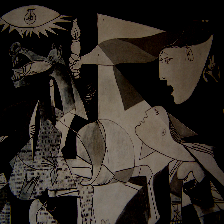

In [9]:
imageFromINDArray(style)

In [10]:
Map<String, INDArray> activationsContentMap = vgg16FineTune.feedForward(content, true);

In [11]:
Arrays.toString(activationsContentMap.get("predictions").shape())

[1, 1000]

In [12]:
activationsContentMap.get("predictions").gt(.2).sum()

0

In [5]:
graph.init()

[IJava-executor-0] INFO org.deeplearning4j.nn.graph.ComputationGraph - Starting ComputationGraph with WorkspaceModes set to [training: ENABLED; inference: ENABLED], cacheMode set to [NONE]
[IJava-executor-0] INFO org.nd4j.linalg.factory.Nd4jBackend - Loaded [CpuBackend] backend
[IJava-executor-0] INFO org.nd4j.nativeblas.NativeOpsHolder - Number of threads used for NativeOps: 4
[IJava-executor-0] INFO org.nd4j.nativeblas.Nd4jBlas - Number of threads used for BLAS: 4
[IJava-executor-0] INFO org.nd4j.linalg.api.ops.executioner.DefaultOpExecutioner - Backend used: [CPU]; OS: [Linux]
[IJava-executor-0] INFO org.nd4j.linalg.api.ops.executioner.DefaultOpExecutioner - Cores: [8]; Memory: [4.9GB];
[IJava-executor-0] INFO org.nd4j.linalg.api.ops.executioner.DefaultOpExecutioner - Blas vendor: [OPENBLAS]


In [6]:
int nIn = 4;
int nHidden = 6;
int nOut = 1;
INDArray W1 = Nd4j.rand(nIn, nOut);

In [36]:
import org.deeplearning4j.nn.conf.ComputationGraphConfiguration;
import org.deeplearning4j.nn.conf.NeuralNetConfiguration;
import org.deeplearning4j.nn.graph.ComputationGraph;
import org.deeplearning4j.nn.conf.layers.DenseLayer;
import org.nd4j.linalg.learning.config.NoOp;
import org.nd4j.linalg.learning.config.Adam;
import org.deeplearning4j.nn.weights.WeightInit;



ComputationGraphConfiguration conf = new NeuralNetConfiguration.Builder()
    .weightInit(WeightInit.XAVIER)
    .graphBuilder()
    .addInputs("input")
    .addLayer("fc1", new DenseLayer.Builder().nIn(nIn).nOut(nOut).build(), "input")
    //.addLayer("fc2", new DenseLayer.Builder().nIn(6).nOut(5).build(), "fc1")
    .setOutputs("fc1")
    .pretrain(false).backprop(true)
    .build();

ComputationGraph graph = new ComputationGraph(conf);
graph.init();

# Manual forward pass in a layer

In [37]:
import org.deeplearning4j.nn.workspace.LayerWorkspaceMgr;
import org.deeplearning4j.nn.gradient.Gradient;
import org.nd4j.linalg.learning.AdamUpdater;
import org.nd4j.linalg.learning.GradientUpdater;
import org.nd4j.linalg.learning.config.Adam;
import org.nd4j.linalg.learning.config.Sgd;
import org.nd4j.linalg.learning.SgdUpdater;

int numBatches = 500;
int batchSize = 50;
int size = numBatches * batchSize;
INDArray X = Nd4j.rand(size, nIn);
INDArray Y = X.mmul(W1).add(1).add(Nd4j.rand(size, nOut).mul(.000001)).reshape(numBatches, batchSize, nOut);
Y.divi(Y.max());
X = X.reshape(numBatches, batchSize, nIn);
int gradientSize = graph.params().shape()[1];
GradientUpdater updater;
//updater = new AdamUpdater(new Adam(1e-4));
updater = new SgdUpdater(new Sgd(1e-4));
updater.setStateViewArray(Nd4j.zeros(1, gradientSize), graph.params().shape(), 'c', true);
INDArray[] inputs;
INDArray diff;
Gradient g;
Map<String, INDArray> map;
inputs = new INDArray[] { null };
int iteration;
for (int epoch=0; epoch<50; epoch++) {
    for (iteration=0; iteration<numBatches; iteration++) {
        inputs[0] = X.getRow(iteration);
        map = graph.feedForward(inputs, true, false); /*the las false is to
        make the model save everything as it goes forward*/
        diff = /*this is the derivative of the loss function
                 to outputs: dL/dy' */
            map.get("fc1").sub(Y.getRow(iteration)).div(batchSize);
        g = graph.backpropGradient(diff); /* g.gradient() now gives 
                                             a flat vector of gradients */
        updater.applyUpdater(g.gradient(), iteration, epoch);
        graph.params().subi(g.gradient());
    }
}

In [16]:
graph.paramTable()

{fc1_W=[0.0223, 
 -0.2373, 
 0.4886, 
 -0.1670], fc1_b=0.6476}

# Layer-wise backpropagation

In [39]:
graph.feedForward(inputs, true, false);
Arrays.toString(graph.getLayer("fc1").backpropGradient(diff, LayerWorkspaceMgr.noWorkspaces()).getSecond().shape());
/*layer.backpropGradient(...) gives 

[50, 4]

In [11]:
import org.deeplearning4j.nn.conf.ComputationGraphConfiguration;
import org.deeplearning4j.nn.conf.NeuralNetConfiguration;
import org.deeplearning4j.nn.graph.ComputationGraph;
import org.deeplearning4j.nn.conf.layers.DenseLayer;
import org.deeplearning4j.nn.conf.layers.OutputLayer;
import org.nd4j.linalg.learning.config.NoOp;
import org.nd4j.linalg.learning.config.Adam;
import org.deeplearning4j.nn.weights.WeightInit;



ComputationGraphConfiguration conf = new NeuralNetConfiguration.Builder()
    .weightInit(WeightInit.XAVIER)
    .graphBuilder()
    .addInputs("input")
    .addLayer("fc1", new OutputLayer.Builder(org.nd4j.linalg.lossfunctions.LossFunctions.LossFunction.MSE)
    .nIn(nIn).nOut(nOut).build(), "input")
    //.addLayer("fc2", new DenseLayer.Builder().nIn(6).nOut(5).build(), "fc1")
    .setOutputs("fc1")
    .pretrain(false).backprop(true)
    .build();

ComputationGraph graph = new ComputationGraph(conf);
graph.init();

In [12]:
import org.deeplearning4j.nn.workspace.LayerWorkspaceMgr;
import org.deeplearning4j.nn.gradient.Gradient;
import org.nd4j.linalg.learning.AdamUpdater;
import org.nd4j.linalg.learning.GradientUpdater;
import org.nd4j.linalg.learning.config.Adam;
import org.nd4j.linalg.learning.config.Sgd;
import org.nd4j.linalg.learning.SgdUpdater;
import org.nd4j.linalg.dataset.DataSet;

int numBatches = 500;
int batchSize = 50;
int size = numBatches * batchSize;
INDArray X = Nd4j.rand(size, nIn);
INDArray Y = X.mmul(W1).add(1).add(Nd4j.rand(size, nOut).mul(.0001)).reshape(numBatches, batchSize, nOut);
Y.divi(Y.max());
X = X.reshape(numBatches, batchSize, nIn);
GradientUpdater updater;
//updater = new AdamUpdater(new Adam(1e-4));
updater = new SgdUpdater(new Sgd(1e-4));
updater.setStateViewArray(Nd4j.zeros(1, 2 * gradientSize), graph.params().shape(), 'c', true);
int gradientSize = graph.params().shape()[1];
INDArray[] inputs;
INDArray diff;
Gradient g;
Map<String, INDArray> map;
inputs = new INDArray[] { null };
int iteration;
for (int epoch=0; epoch<500; epoch++) {
    for (iteration=0; iteration<numBatches; iteration++) {
        graph.fit(new DataSet(X.getRow(iteration), Y.getRow(iteration)));
    }
}

In [13]:
graph.paramTable()

{fc1_W=[0.3125, 
 0.7098, 
 1.1181, 
 0.3111], fc1_b=-0.4688}

In [ ]:
ComputationGraphConfiguration conf = new NeuralNetConfiguration.Builder()
    .weightInit(WeightInit.XAVIER)
    .graphBuilder()
    .addInputs("input1")
    .addInputs("input2")
    .addLayer("fc1", new OutputLayer.Builder(org.nd4j.linalg.lossfunctions.LossFunctions.LossFunction.MSE)
    .nIn(nIn).nOut(nOut).build(), "input")
    //.addLayer("fc2", new DenseLayer.Builder().nIn(6).nOut(5).build(), "fc1")
    .setOutputs("fc1")
    .pretrain(false).backprop(true)
    .build();

ComputationGraph graph = new ComputationGraph(conf);
graph.init();